In [314]:
import pandas as pd
import numpy as np

In [315]:
%pwd

'/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow/data/round4/preprocessed'

In [316]:
%cd ../../../data/round4/preprocessed

/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow/data/round4/preprocessed


In [317]:
%ls

day0.csv            day2.csv            mid_price_day0.csv  mid_price_day2.csv
day1.csv            day3.csv            mid_price_day1.csv  mid_price_day3.csv


In [318]:
df_mid_0 = pd.read_csv('mid_price_day0.csv')
df_mid_1 = pd.read_csv('mid_price_day1.csv')
df_mid_2 = pd.read_csv('mid_price_day2.csv')
df_mid_3 = pd.read_csv('mid_price_day3.csv')

In [319]:
df_mid_0['T'] = (8 - df_mid_0['timestamp'] * 0.0001 / 100  ) / 365
df_mid_1['T'] = (7 - df_mid_1['timestamp'] * 0.0001 / 100  ) / 365
df_mid_2['T'] = (6 - df_mid_2['timestamp'] * 0.0001 / 100  ) / 365
df_mid_3['T'] = (5 - df_mid_3['timestamp'] * 0.0001 / 100  ) / 365

In [320]:
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import numpy as np

def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def implied_volatility(S, K, T, r, market_price):
    loss_fn = lambda sigma: (bs_call_price(S, K, T, r, sigma) - market_price)**2
    result = minimize_scalar(loss_fn, bounds=(1e-4, 3.0), method='bounded')
    return result.x

def calculate_iv(df):
    df = df.copy()
    strick_prices = [9500, 9750, 10000, 10250, 10500]
    for strick_price in strick_prices:
        df['iv_' + str(strick_price)] = df.apply(lambda row: implied_volatility(
            row['VOLCANIC_ROCK'], strick_price, row['T'], 0, row['VOLCANIC_ROCK_VOUCHER_' + str(strick_price)]), axis=1)
    return df

def calculate_moneyness(df):
    df = df.copy()
    strike_prices = [9500, 9750, 10000, 10250, 10500]
    for strike in strike_prices:
        df[f'm_{strike}'] = df.apply(lambda row: np.log(strike / row['VOLCANIC_ROCK']) / np.sqrt(row['T']), axis=1)
    return df

def fit_iv_curve(df):
    """返回每个时间点 t 的 beta 系数（β₀, β₁, β₂），强制 β₂ ≥ 0"""
    betas = []

    for idx, row in df.iterrows():
        m_values = []
        iv_values = []

        for strike in [9500, 9750, 10000, 10250, 10500]:
            m = row[f'm_{strike}']
            iv = row[f'iv_{strike}']
            if 0 < iv < 2:  # 排除极端值
                m_values.append(m)
                iv_values.append(iv)

        if len(m_values) >= 3:
            # 第一次完整拟合
            X_full = np.column_stack([np.ones(len(m_values)), 
                                    m_values, 
                                    np.square(m_values)])
            beta = np.linalg.lstsq(X_full, iv_values, rcond=None)[0]
            
            # 如果 β₂ < 0，则使用上一组数据
            if beta[2] < 0:
                if len(betas) > 1:
                    beta = betas[-1]
                else:
                    beta = [0,0,0]
        
        else:
            beta = [np.nan, np.nan, np.nan]

        betas.append(beta)

    df[['beta_0', 'beta_1', 'beta_2']] = pd.DataFrame(betas, index=df.index)
    return df


def add_fitted_ivs(df, strike_prices=[9500, 9750, 10000, 10250, 10500]):
    df = df.copy()
    for strike in strike_prices:
        m_col = f'm_{strike}'
        fitted_col = f'fitted_iv_{strike}'
        df[fitted_col] = df.apply(
            lambda row: row['beta_0'] + row['beta_1'] * row[m_col] + row['beta_2'] * row[m_col]**2
            if not np.isnan(row['beta_0']) and not np.isnan(row[m_col]) else np.nan,
            axis=1
        )
    return df

def calculate_base_iv(df):
    df['base_iv'] = df['beta_0']  # 因为在 m = 0 时，β₁·m + β₂·m² 都为0
    return df

In [321]:
def preprocess(df):
    df = df.copy()
    df = calculate_iv(df)
    df = calculate_moneyness(df)
    df = fit_iv_curve(df)
    df = add_fitted_ivs(df)
    df = calculate_base_iv(df)
    return df

In [322]:
df_mid_0 = preprocess(df_mid_0)
df_mid_1 = preprocess(df_mid_1)
df_mid_2 = preprocess(df_mid_2)
df_mid_3 = preprocess(df_mid_3)

In [323]:
df_mid_0.to_csv('day0.csv', index=False)
df_mid_1.to_csv('day1.csv', index=False)
df_mid_2.to_csv('day2.csv', index=False)
df_mid_3.to_csv('day3.csv', index=False)

In [324]:
df_mid_1

,timestamp,day,VOLCANIC_ROCK,VOLCANIC_ROCK_VOUCHER_9500,VOLCANIC_ROCK_VOUCHER_9750,VOLCANIC_ROCK_VOUCHER_10000,VOLCANIC_ROCK_VOUCHER_10250,VOLCANIC_ROCK_VOUCHER_10500,T,iv_9500,...,m_10500,beta_0,beta_1,beta_2,fitted_iv_9500,fitted_iv_9750,fitted_iv_10000,fitted_iv_10250,fitted_iv_10500,base_iv
0,0,1,10516.0,1016.0,766.5,517.5,279.5,95.5,0.019178,0.077439,...,-0.010995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,100,1,10515.0,1015.5,765.5,516.5,278.5,94.5,0.019178,0.277959,...,-0.010308,0.151841,0.048350,0.298931,0.277019,0.214404,0.173616,0.153085,0.151374,0.151841
2,200,1,10515.0,1015.5,765.5,516.5,278.5,94.5,0.019178,0.277961,...,-0.010309,0.151842,0.048350,0.298929,0.277021,0.214406,0.173618,0.153086,0.151375,0.151842
3,300,1,10517.0,1017.5,767.5,519.5,280.5,95.5,0.019177,0.278426,...,-0.011682,0.150258,0.000515,0.234080,0.276129,0.219970,0.181085,0.158234,0.150284,0.150258
4,400,1,10519.5,1019.5,770.5,521.5,282.5,97.5,0.019177,0.077624,...,-0.013398,0.150258,0.000515,0.234080,0.276720,0.220411,0.181378,0.158383,0.150293,0.150258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,999500,1,10224.5,725.5,476.5,237.5,66.5,9.5,0.016440,0.244734,...,0.207370,0.146583,0.003739,0.302285,0.243760,0.186718,0.154999,0.146770,0.160357,0.146583
9996,999600,1,10225.5,725.5,477.5,237.5,66.5,9.5,0.016439,0.059180,...,0.206609,0.146583,0.003739,0.302285,0.244023,0.186887,0.155076,0.146758,0.160259,0.146583
9997,999700,1,10222.0,722.5,472.5,234.5,64.5,9.5,0.016439,0.224787,...,0.209281,0.141494,0.043546,0.312016,0.218455,0.167856,0.143187,0.142565,0.164273,0.141494
9998,999800,1,10223.5,723.5,474.5,237.5,65.5,9.5,0.016439,0.059055,...,0.208138,0.141494,0.043546,0.312016,0.218815,0.168071,0.143260,0.142500,0.164074,0.141494


In [325]:
df0 = pd.read_csv('day0.csv')
df1 = pd.read_csv('day1.csv')
df1['timestamp'] = df1['timestamp'] + 1000000
df2 = pd.read_csv('day2.csv')
df2['timestamp'] = df2['timestamp'] + 2000000
df3 = pd.read_csv('day3.csv')
df3['timestamp'] = df3['timestamp'] + 3000000
df = pd.concat([df0, df1, df2, df3], ignore_index=True)


In [326]:
slice = df1[df1['timestamp'] == 1750000]
slice

,timestamp,day,VOLCANIC_ROCK,VOLCANIC_ROCK_VOUCHER_9500,VOLCANIC_ROCK_VOUCHER_9750,VOLCANIC_ROCK_VOUCHER_10000,VOLCANIC_ROCK_VOUCHER_10250,VOLCANIC_ROCK_VOUCHER_10500,T,iv_9500,...,m_10500,beta_0,beta_1,beta_2,fitted_iv_9500,fitted_iv_9750,fitted_iv_10000,fitted_iv_10250,fitted_iv_10500,base_iv
7500,1750000,1,10305.0,805.0,555.5,313.5,111.5,19.5,0.017123,0.07013,...,0.143257,0.149217,-0.001027,0.241177,0.243036,0.19282,0.162166,0.149662,0.154019,0.149217


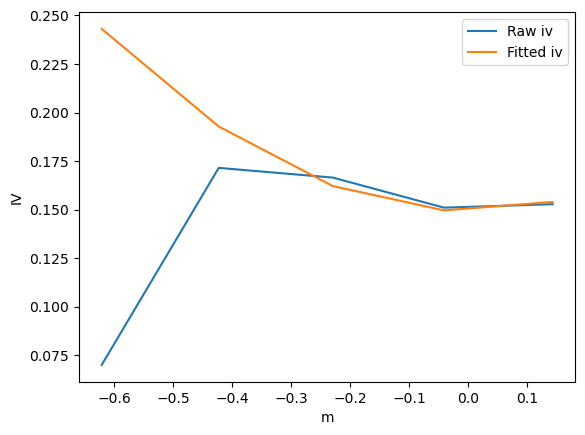

In [327]:
import matplotlib.pyplot as plt
raw_ivs = [slice['iv_9500'], slice['iv_9750'], slice['iv_10000'], slice['iv_10250'], slice['iv_10500']]
ivs = [slice['fitted_iv_9500'], slice['fitted_iv_9750'], slice['fitted_iv_10000'], slice['fitted_iv_10250'], slice['fitted_iv_10500']]
ms = [slice['m_9500'], slice['m_9750'], slice['m_10000'], slice['m_10250'], slice['m_10500']]

plt.plot(ms, raw_ivs, label = 'Raw iv')
plt.plot(ms, ivs, label = 'Fitted iv')
#plt.axhline(y = slice['base_iv'].values[0], color = 'red')
plt.xlabel('m')
plt.ylabel('IV')
plt.legend()

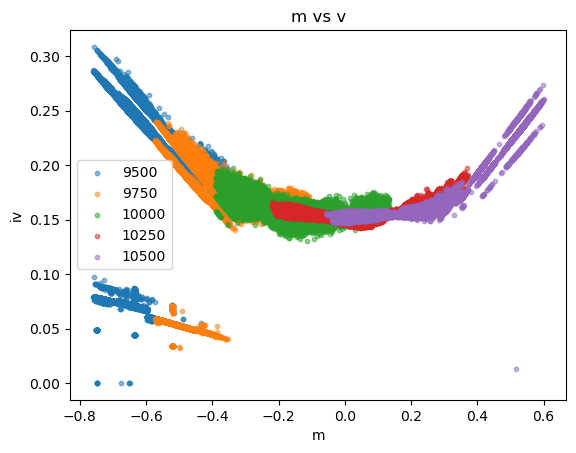

In [328]:
#画出m, iv散点图
import pandas as pd
import matplotlib.pyplot as plt

plt.scatter(df['m_9500'], df['iv_9500'], s=10, alpha=0.5, label = '9500')
plt.scatter(df['m_9750'], df['iv_9750'], s=10, alpha=0.5, label = '9750')
plt.scatter(df['m_10000'], df['iv_10000'], s=10, alpha=0.5, label = '10000')
plt.scatter(df['m_10250'], df['iv_10250'], s=10, alpha=0.5, label = '10250')
plt.scatter(df['m_10500'], df['iv_10500'], s=10, alpha=0.5, label = '10500')
plt.title('m vs v')
plt.xlabel('m')
plt.ylabel('iv')
plt.legend()
plt.show()

In [329]:
import numpy as np

def fit_piecewise_vol_surface(m, iv, m1=-0.4, m2=0.4):
    m = np.array(m)
    iv = np.array(iv)

    # 分段
    idx_left = m < m1
    idx_mid = (m >= m1) & (m <= m2)
    idx_right = m > m2

    # 左段：线性拟合
    if np.sum(idx_left) >= 2:
        X_left = np.column_stack([np.ones(np.sum(idx_left)), m[idx_left]])
        beta_left = np.linalg.lstsq(X_left, iv[idx_left], rcond=None)[0]
    else:
        beta_left = [iv[idx_left][0] if np.any(idx_left) else iv[0], 0.0]  # fallback

    # 中段：二次拟合
    if np.sum(idx_mid) >= 3:
        X_mid = np.column_stack([np.ones(np.sum(idx_mid)), m[idx_mid], m[idx_mid]**2])
        beta_mid = np.linalg.lstsq(X_mid, iv[idx_mid], rcond=None)[0]
    else:
        beta_mid = [np.mean(iv[idx_mid]) if np.any(idx_mid) else iv[0], 0.0, 1e-4]

    # 右段：线性拟合
    if np.sum(idx_right) >= 2:
        X_right = np.column_stack([np.ones(np.sum(idx_right)), m[idx_right]])
        beta_right = np.linalg.lstsq(X_right, iv[idx_right], rcond=None)[0]
    else:
        beta_right = [iv[idx_right][0] if np.any(idx_right) else iv[-1], 0.0]

    # 输出三个区域的系数
    return {
        'left': beta_left,
        'mid': beta_mid,
        'right': beta_right,
        'm1': m1,
        'm2': m2,
    }

def predict_piecewise_iv(m_val, coef):
    m1 = coef['m1']
    m2 = coef['m2']

    if m_val < m1:
        b0, b1 = coef['left']
        return b0 + b1 * m_val
    elif m_val > m2:
        b0, b1 = coef['right']
        return b0 + b1 * m_val
    else:
        b0, b1, b2 = coef['mid']
        return b0 + b1 * m_val + b2 * m_val ** 2

0.1299034929406697
Piecewise Vol Surface Coefficients: {'left': array([ 0.05905151, -0.29587221]), 'mid': array([1.50945826e-01, 8.62732927e-05, 1.94416787e-01]), 'right': array([0.05307743, 0.33944394]), 'm1': -0.4, 'm2': 0.4}


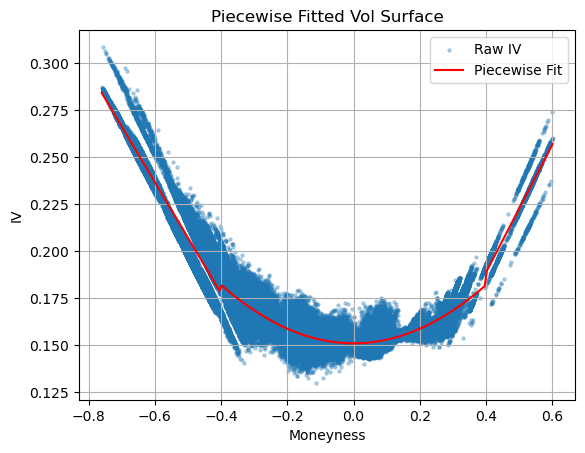

In [330]:
m_all = np.concatenate([
    df['m_9500'].values,
    df['m_9750'].values,
    df['m_10000'].values,
    df['m_10250'].values,
    df['m_10500'].values
])

# 所有 iv 拼接在一起
iv_all = np.concatenate([
    df['iv_9500'].values,
    df['iv_9750'].values,
    df['iv_10000'].values,
    df['iv_10250'].values,
    df['iv_10500'].values
])

mask = iv_all >= 0.125
m_all = m_all[mask]
iv_all = iv_all[mask]
print(min(iv_all))

# 调用函数拟合三段式 smile
vol_surface_coef = fit_piecewise_vol_surface(m_all, iv_all)
print('Piecewise Vol Surface Coefficients:', vol_surface_coef)

# 画原始散点
plt.scatter(m_all, iv_all, s=5, alpha=0.3, label='Raw IV')

# 拟合线：在一系列 m 上计算拟合值
m_range = np.linspace(m_all.min(), m_all.max(), 200)
fitted_iv = [predict_piecewise_iv(m, vol_surface_coef) for m in m_range]

# 画拟合曲线
plt.plot(m_range, fitted_iv, color='red', label='Piecewise Fit')

plt.legend()
plt.xlabel('Moneyness')
plt.ylabel('IV')
plt.title('Piecewise Fitted Vol Surface')
plt.grid(True)
plt.show()

In [331]:
from sklearn.mixture import GaussianMixture
import numpy as np

# 数据准备（reshape 为 GMM 所需格式）
X = df['base_iv'].dropna().values.reshape(-1, 1)

# 用 2 个分布拟合
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X)

# 预测每个时刻的 regime（状态标签）
regimes = gmm.predict(X)

# 将 regime 标签加入原始 df（需要对齐索引）
df = df.loc[df['base_iv'].notnull()].copy()
df['base_iv_regime'] = regimes

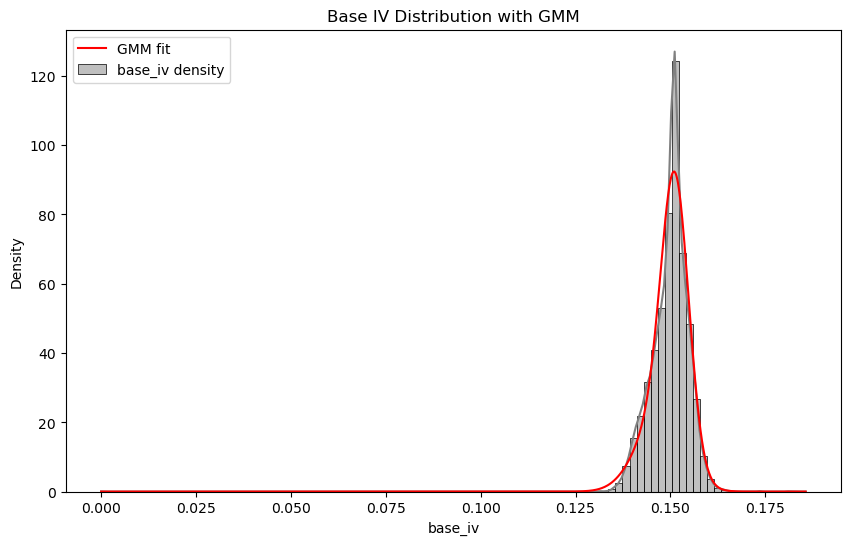

In [332]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['base_iv'], bins=100, kde=True, color='gray', stat='density', label='base_iv density')

# 画出 GMM 拟合的两个正态分布
x = np.linspace(df['base_iv'].min(), df['base_iv'].max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)
plt.plot(x, pdf, label='GMM fit', color='red')

plt.title("Base IV Distribution with GMM")
plt.legend()
plt.show()

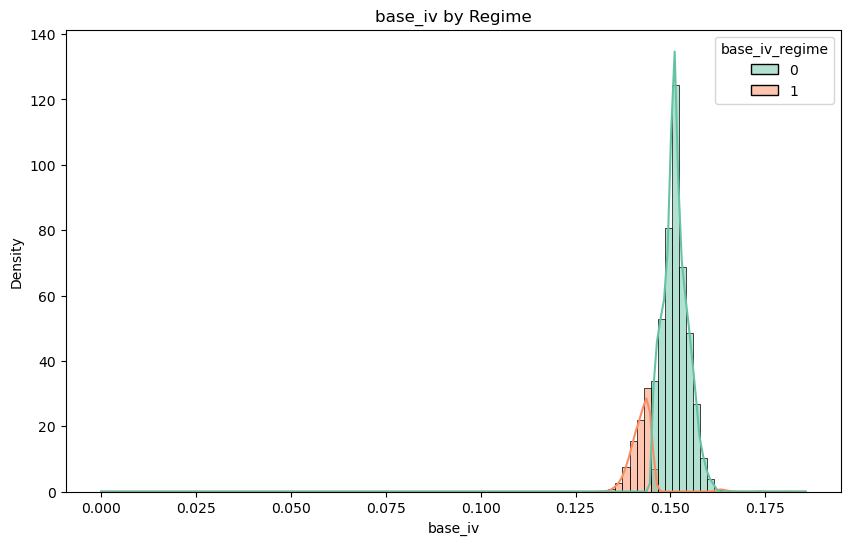

In [333]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='base_iv', hue='base_iv_regime', bins=100, stat='density', kde=True, palette='Set2')
plt.title("base_iv by Regime")
plt.show()

In [334]:
#去除异常iv
columns = ['iv_9500', 'iv_9750', 'iv_10000', 'iv_10250', 'iv_10500']
#如果iv < 0.14，就用最小值0.145代替    
for column in columns:
    df[column] = df[column].apply(lambda x: 0.145 if x < 0.14 else x)


In [335]:
df['delta_iv_9500'] = df['fitted_iv_9500'] - df['iv_9500']
df['delta_iv_9750'] = df['fitted_iv_9750'] - df['iv_9750']
df['delta_iv_10000'] = df['fitted_iv_10000'] - df['iv_10000']
df['delta_iv_10250'] = df['fitted_iv_10250'] - df['iv_10250']
df['delta_iv_10500'] = df['fitted_iv_10500'] - df['iv_10500']

In [336]:
df_regime0 = df[df['base_iv_regime'] == 0]
df_regime1 = df[df['base_iv_regime'] == 1]
#分界线
print(max(df_regime0['base_iv']))
print(len(df_regime0), len(df_regime1))

0.1620821127673637
33432 6568


In [337]:
print(df.columns)

Index(['timestamp', 'VOLCANIC_ROCK', 'VOLCANIC_ROCK_VOUCHER_9500',
       'VOLCANIC_ROCK_VOUCHER_9750', 'VOLCANIC_ROCK_VOUCHER_10000',
       'VOLCANIC_ROCK_VOUCHER_10250', 'VOLCANIC_ROCK_VOUCHER_10500', 'T',
       'iv_9500', 'iv_9750', 'iv_10000', 'iv_10250', 'iv_10500', 'm_9500',
       'm_9750', 'm_10000', 'm_10250', 'm_10500', 'beta_0', 'beta_1', 'beta_2',
       'fitted_iv_9500', 'fitted_iv_9750', 'fitted_iv_10000',
       'fitted_iv_10250', 'fitted_iv_10500', 'base_iv', 'day',
       'base_iv_regime', 'delta_iv_9500', 'delta_iv_9750', 'delta_iv_10000',
       'delta_iv_10250', 'delta_iv_10500'],
      dtype='object')


-0.0038498685974801146 0.12622984473438942
-0.005844747571057833 0.10942490892271031


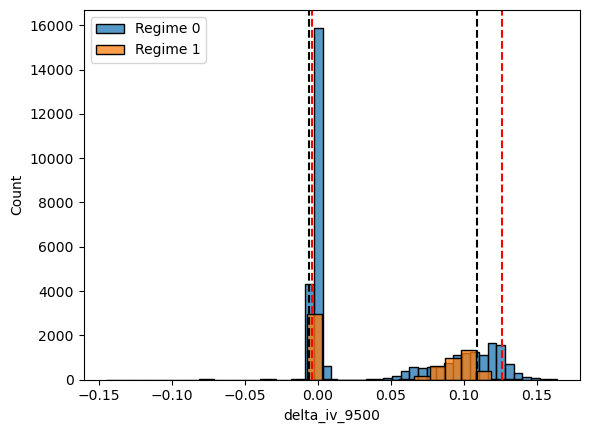

In [338]:
import seaborn as sns
sns.histplot(df_regime0['delta_iv_9500'], label = 'Regime 0')
sns.histplot(df_regime1['delta_iv_9500'], label = 'Regime 1')
plt.axvline(x=df_regime0['delta_iv_9500'].quantile(0.05), color='red', linestyle='--')
plt.axvline(x=df_regime0['delta_iv_9500'].quantile(0.95), color='red', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_9500'].quantile(0.05), color='black', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_9500'].quantile(0.95), color='black', linestyle='--')
print(df_regime0['delta_iv_9500'].quantile(0.05), df_regime0['delta_iv_9500'].quantile(0.95))
print(df_regime1['delta_iv_9500'].quantile(0.05), df_regime1['delta_iv_9500'].quantile(0.95))

plt.legend()

-0.00900384057959154 0.01451750844881326
0.0003453581406230161 0.009993823021192394


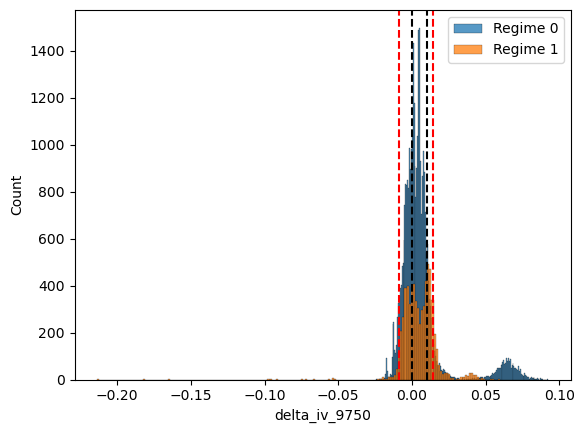

In [339]:
import seaborn as sns
sns.histplot(df_regime0['delta_iv_9750'], label = 'Regime 0')
sns.histplot(df_regime1['delta_iv_9750'], label = 'Regime 1')
plt.axvline(x=df_regime0['delta_iv_9750'].quantile(0.05), color='red', linestyle='--')
plt.axvline(x=df_regime0['delta_iv_9750'].quantile(0.9), color='red', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_9750'].quantile(0.33), color='black', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_9750'].quantile(0.67), color='black', linestyle='--')
print(df_regime0['delta_iv_9750'].quantile(0.05), df_regime0['delta_iv_9750'].quantile(0.9))
print(df_regime1['delta_iv_9750'].quantile(0.33), df_regime1['delta_iv_9750'].quantile(0.67))
plt.legend()

-0.008468494167303565 0.008745063033321579
-0.013056112107656972 0.005222796970827227


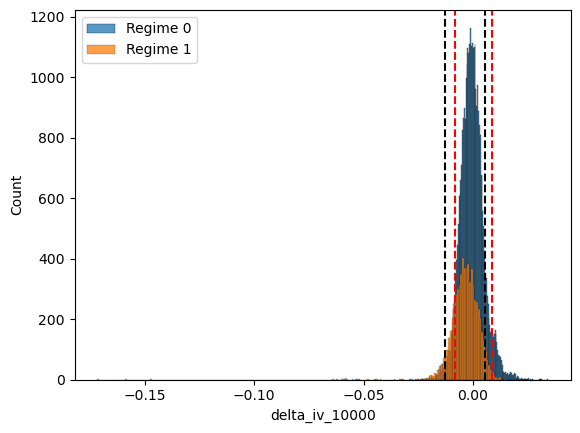

In [340]:
sns.histplot(df_regime0['delta_iv_10000'], label = 'Regime 0')
sns.histplot(df_regime1['delta_iv_10000'], label = 'Regime 1')

plt.axvline(x=df_regime0['delta_iv_10000'].quantile(0.05), color='red', linestyle='--')
plt.axvline(x=df_regime0['delta_iv_10000'].quantile(0.95), color='red', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_10000'].quantile(0.05), color='black', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_10000'].quantile(0.95), color='black', linestyle='--')
print(df_regime0['delta_iv_10000'].quantile(0.05), df_regime0['delta_iv_10000'].quantile(0.95))
print(df_regime1['delta_iv_10000'].quantile(0.05), df_regime1['delta_iv_10000'].quantile(0.95))

plt.legend()

-0.00525142081158617 0.004890683918744791
-0.007614174650262989 -0.0006414534144517652


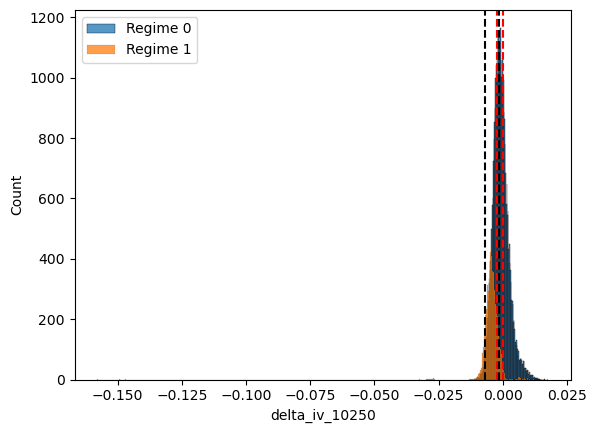

In [341]:
sns.histplot(df_regime0['delta_iv_10250'], label = 'Regime 0')
sns.histplot(df_regime1['delta_iv_10250'], label = 'Regime 1')
plt.axvline(x=df_regime0['delta_iv_10250'].quantile(0.33), color='red', linestyle='--')
plt.axvline(x=df_regime0['delta_iv_10250'].quantile(0.67), color='red', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_10250'].quantile(0.1), color='black', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_10250'].quantile(0.9), color='black', linestyle='--')
print(df_regime0['delta_iv_10250'].quantile(0.05), df_regime0['delta_iv_10250'].quantile(0.95))
print(df_regime1['delta_iv_10250'].quantile(0.05), df_regime1['delta_iv_10250'].quantile(0.95))
plt.legend()

4.3531271175380166e-05 0.0015728752722162032
0.001945155229180171 0.003519244943108311


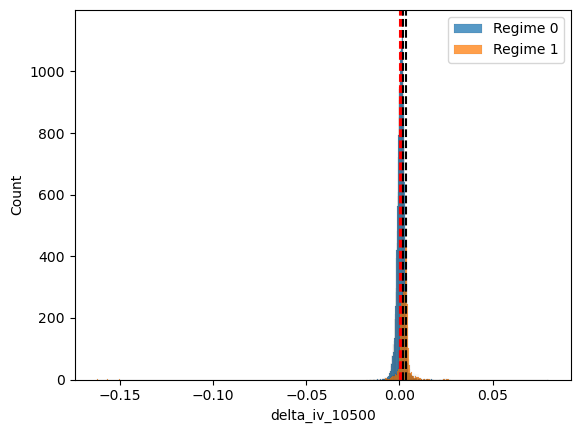

In [342]:
import seaborn as sns
sns.histplot(df_regime0['delta_iv_10500'], label = 'Regime 0')
sns.histplot(df_regime1['delta_iv_10500'], label = 'Regime 1')
plt.axvline(x=df_regime0['delta_iv_10500'].quantile(0.33), color='red', linestyle='--')
plt.axvline(x=df_regime0['delta_iv_10500'].quantile(0.67), color='red', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_10500'].quantile(0.33), color='black', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_10500'].quantile(0.67), color='black', linestyle='--')
print(df_regime0['delta_iv_10500'].quantile(0.33), df_regime0['delta_iv_10500'].quantile(0.67))
print(df_regime1['delta_iv_10500'].quantile(0.33), df_regime1['delta_iv_10500'].quantile(0.67))

plt.legend()

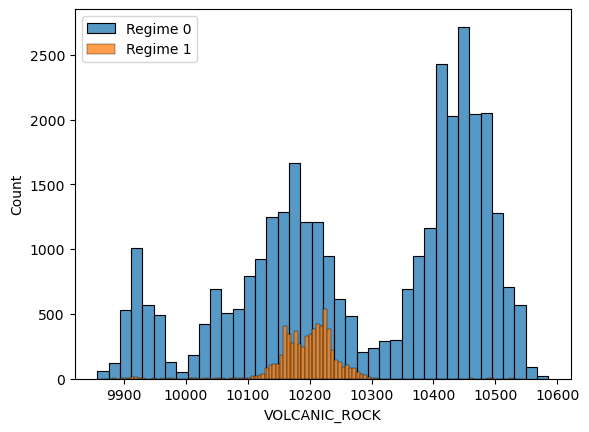

In [343]:
sns.histplot(df_regime0['VOLCANIC_ROCK'], label = 'Regime 0')
sns.histplot(df_regime1['VOLCANIC_ROCK'], label = 'Regime 1')
plt.legend()

In [344]:
df['VOLCANIC_ROCK_diff'] = df['VOLCANIC_ROCK'] - df['VOLCANIC_ROCK'].shift(1)
df['VOLCANIC_ROCK_vol20'] = df['VOLCANIC_ROCK_diff'].rolling(window=20).std()
df.dropna(inplace = True)

In [345]:
df_regime0 = df[df['base_iv_regime'] == 0]
df_regime1 = df[df['base_iv_regime'] == 1]

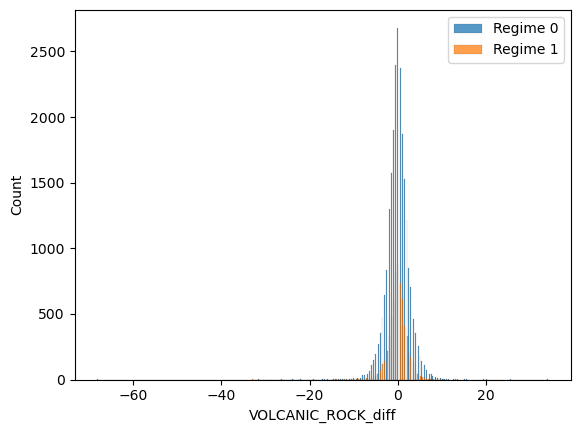

In [346]:
sns.histplot(df_regime0['VOLCANIC_ROCK_diff'], label = 'Regime 0')
sns.histplot(df_regime1['VOLCANIC_ROCK_diff'], label = 'Regime 1')
plt.legend()

In [347]:
up_quantile = 0.6
down_quantile = 0.4
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9500 for regime0: {df_regime0['delta_iv_9500'].quantile(down_quantile)}, {df_regime0['delta_iv_9500'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9500 for regime1: {df_regime1['delta_iv_9500'].quantile(down_quantile)}, {df_regime1['delta_iv_9500'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9750 for regime0: {df_regime0['delta_iv_9750'].quantile(down_quantile)}, {df_regime0['delta_iv_9750'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9750 for regime1: {df_regime1['delta_iv_9750'].quantile(down_quantile)}, {df_regime1['delta_iv_9750'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10000 for regime0: {df_regime0['delta_iv_10000'].quantile(down_quantile)}, {df_regime0['delta_iv_10000'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10000 for regime1: {df_regime1['delta_iv_10000'].quantile(down_quantile)}, {df_regime1['delta_iv_10000'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10250 for regime0: {df_regime0['delta_iv_10250'].quantile(down_quantile)}, {df_regime0['delta_iv_10250'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10250 for regime1: {df_regime1['delta_iv_10250'].quantile(down_quantile)}, {df_regime1['delta_iv_10250'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10500 for regime0: {df_regime0['delta_iv_10500'].quantile(down_quantile)}, {df_regime0['delta_iv_10500'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10500 for regime1: {df_regime1['delta_iv_10500'].quantile(down_quantile)}, {df_regime1['delta_iv_10500'].quantile(up_quantile)}")



0.4, 0.6 quantile of delta_iv_9500 for regime0: 0.00021981662171181138, 0.0027856569125892117
0.4, 0.6 quantile of delta_iv_9500 for regime1: -7.654421571023917e-07, 0.0887147249542447
0.4, 0.6 quantile of delta_iv_9750 for regime0: 0.000583391579792775, 0.0043735862270892255
0.4, 0.6 quantile of delta_iv_9750 for regime1: 0.0019957815960889858, 0.008218668180717703
0.4, 0.6 quantile of delta_iv_10000 for regime0: -0.0017857049838883973, 0.00038358489623693766
0.4, 0.6 quantile of delta_iv_10000 for regime1: -0.004807613418414292, -0.0020155417899279937
0.4, 0.6 quantile of delta_iv_10250 for regime0: -0.0013624718504301801, 2.137925012442495e-05
0.4, 0.6 quantile of delta_iv_10250 for regime1: -0.004840935786684514, -0.003874519889466216
0.4, 0.6 quantile of delta_iv_10500 for regime0: 0.00019688298423372052, 0.0010656294912144146
0.4, 0.6 quantile of delta_iv_10500 for regime1: 0.0023285712773538914, 0.003281703182907908


In [348]:
up_quantile = 0.95
down_quantile = 0.05
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9500 for regime0: {df_regime0['delta_iv_9500'].quantile(down_quantile)}, {df_regime0['delta_iv_9500'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9500 for regime1: {df_regime1['delta_iv_9500'].quantile(down_quantile)}, {df_regime1['delta_iv_9500'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9750 for regime0: {df_regime0['delta_iv_9750'].quantile(down_quantile)}, {df_regime0['delta_iv_9750'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9750 for regime1: {df_regime1['delta_iv_9750'].quantile(down_quantile)}, {df_regime1['delta_iv_9750'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10000 for regime0: {df_regime0['delta_iv_10000'].quantile(down_quantile)}, {df_regime0['delta_iv_10000'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10000 for regime1: {df_regime1['delta_iv_10000'].quantile(down_quantile)}, {df_regime1['delta_iv_10000'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10250 for regime0: {df_regime0['delta_iv_10250'].quantile(down_quantile)}, {df_regime0['delta_iv_10250'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10250 for regime1: {df_regime1['delta_iv_10250'].quantile(down_quantile)}, {df_regime1['delta_iv_10250'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10500 for regime0: {df_regime0['delta_iv_10500'].quantile(down_quantile)}, {df_regime0['delta_iv_10500'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10500 for regime1: {df_regime1['delta_iv_10500'].quantile(down_quantile)}, {df_regime1['delta_iv_10500'].quantile(up_quantile)}")



0.05, 0.95 quantile of delta_iv_9500 for regime0: -0.0032768556055094537, 0.12404792961932969
0.05, 0.95 quantile of delta_iv_9500 for regime1: -0.005828324283347758, 0.10942950617964145
0.05, 0.95 quantile of delta_iv_9750 for regime0: -0.009018721746318964, 0.0447217508766871
0.05, 0.95 quantile of delta_iv_9750 for regime1: -0.007237373868184557, 0.019557977664969445
0.05, 0.95 quantile of delta_iv_10000 for regime0: -0.008063473661251087, 0.008067688083375334
0.05, 0.95 quantile of delta_iv_10000 for regime1: -0.012904638628844098, 0.005225441819082452
0.05, 0.95 quantile of delta_iv_10250 for regime0: -0.0048557622206846784, 0.005828688145047511
0.05, 0.95 quantile of delta_iv_10250 for regime1: -0.007562247244011694, -0.0006400347503999482
0.05, 0.95 quantile of delta_iv_10500 for regime0: -0.0029165506323579338, 0.0031112033672270494
0.05, 0.95 quantile of delta_iv_10500 for regime1: -0.0002822875163116384, 0.005495630526706749
